#  Quant Portfolio: Backtesting

By Joe Osborne: joe.osborne1337@gmail.com

Some of the techniques I use are from Hilpisch's Python for Finance: Mastering Data-Driven Finance 2nd Ed


Contents
### Data retrival
### Mean Reversion Strategy
##### For All Symbols
##### Optimize SMA1 and SMA2
##### Frequency Approach
### Machine Learning Classification
##### Two Binary Features
##### Five Binary Features
##### Five Digitized Features
##### Sequential Test-Train Splits
##### Random Test-Train Splits 
### Deep Neural Networks
##### DNN with Scikit-learn
##### DNN with TensorFlow

## Data retrival

First, we must import libraries...

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

... and style our plots

In [2]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

Second, we must retrive the financial data. (From Hilpisch for now).

In [3]:
raw = pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)

In [4]:
raw.info()

data = (pd.DataFrame(raw).dropna());
symbols = list(raw)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2216 entries, 2010-01-01 to 2018-06-29
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2138 non-null   float64
 1   MSFT.O  2138 non-null   float64
 2   INTC.O  2138 non-null   float64
 3   AMZN.O  2138 non-null   float64
 4   GS.N    2138 non-null   float64
 5   SPY     2138 non-null   float64
 6   .SPX    2138 non-null   float64
 7   .VIX    2138 non-null   float64
 8   EUR=    2216 non-null   float64
 9   XAU=    2211 non-null   float64
 10  GDX     2138 non-null   float64
 11  GLD     2138 non-null   float64
dtypes: float64(12)
memory usage: 225.1 KB


## Mean Reversion Strategy

This strategy uses a short term and long term moving average. The long term moving average lags the short term moving average. When they cross over, it indicates a change in trend.

When the short-term moving average rises through the long-term this indicates a bullish phase and when the short-term moving average slips below the long-term moving average this indicates a bearish phase.

This strategy ignores:
- Transactional costs
- Portfolio composition and optimization
    - Diversity
    - Risky and risk-less asset composition
    - Initial equity and leverage ratio

In [5]:
MAs = {'2mo': 42, '12mo': 252}; # in days
symbol = symbols[0]; 

for MA in MAs:
    data[symbol+'_MA_'+MA] = data[symbol].rolling(MAs[MA]).mean()        
data.dropna(inplace=True)

In [6]:
data.head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD,AAPL.O_MA_2mo,AAPL.O_MA_12mo
Date,,,,,,,,,,,,,,
2010-12-31,46.079954,27.9100,21.03,180.00,168.16,125.75,1257.64,17.75,1.3377,1419.45,61.47,138.72,45.280967,37.120735
2011-01-03,47.081381,27.9800,20.85,184.22,173.05,127.05,1271.87,17.61,1.3351,1413.80,60.77,138.00,45.349708,37.186246
2011-01-04,47.327096,28.0875,21.15,185.01,173.08,126.98,1270.20,17.38,1.3301,1380.21,59.02,134.75,45.412599,37.252521
2011-01-05,47.714238,28.0000,20.94,187.42,174.00,127.64,1276.56,17.02,1.3151,1376.80,58.22,134.37,45.466102,37.322266
2011-01-06,47.675667,28.8200,20.77,185.86,172.21,127.39,1273.85,17.40,1.3001,1371.00,56.74,133.83,45.522565,37.392079


In [7]:
MA_symbols = [symbol,symbol+'_MA_'+'2mo',symbol+'_MA_12mo'];

#Buy when short term moving average is > long term, sell vice versa
data[symbol+'_Position'] = np.where(data[symbol+'_MA_'+'2mo'] > data[symbol+'_MA_'+'12mo'], 1, -1)

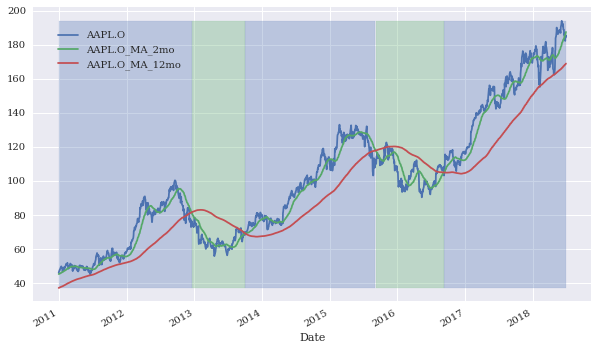

In [8]:
#Without position plotted
ax = data[MA_symbols].plot(figsize=(10, 6))

#With position plotted
#ax = data.plot( secondary_y=symbol+'_Position', figsize=(10, 6))

ax.get_legend().set_bbox_to_anchor((0.28, 0.95));

#Shade between moving averages
#ax.fill_between(data.index, data[symbol+'_MA_'+'2mo'].values, data[symbol+'_MA_'+'12mo'].values,\
#                 where=(data[symbol+'_MA_'+'2mo'].values > data[symbol+'_MA_'+'12mo'].values), color='C0', alpha=0.3)
#ax.fill_between(data.index, data[symbol+'_MA_'+'2mo'].values, data[symbol+'_MA_'+'12mo'].values,\
#                 where=(data[symbol+'_MA_'+'2mo'].values < data[symbol+'_MA_'+'12mo'].values), color='C1', alpha=0.3)

#Shade whole figure
min = data[MA_symbols].min().min()
max = data[MA_symbols].max().max()
ax.fill_between(data.index, min, max,where=(data[symbol+'_MA_'+'2mo'].values > data[symbol+'_MA_'+'12mo'].values),\
                color='C0', alpha=0.3)
ax.fill_between(data.index, min, max,where=(data[symbol+'_MA_'+'2mo'].values < data[symbol+'_MA_'+'12mo'].values),\
                color='C1', alpha=0.3)

In [9]:
data[symbol+'_Returns'] = np.log(data[symbol] / data[symbol].shift(1))  

In [10]:
data[symbol+'_Strategy'] = data[symbol+'_Position'].shift(1) * data[symbol+'_Returns']
data.dropna(inplace=True)

In [11]:
data.head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD,AAPL.O_MA_2mo,AAPL.O_MA_12mo,AAPL.O_Position,AAPL.O_Returns,AAPL.O_Strategy
Date,,,,,,,,,,,,,,,,,
2011-01-03,47.081381,27.9800,20.85,184.22,173.05,127.05,1271.87,17.61,1.3351,1413.80,60.77,138.00,45.349708,37.186246,1,0.021500,0.021500
2011-01-04,47.327096,28.0875,21.15,185.01,173.08,126.98,1270.20,17.38,1.3301,1380.21,59.02,134.75,45.412599,37.252521,1,0.005205,0.005205
2011-01-05,47.714238,28.0000,20.94,187.42,174.00,127.64,1276.56,17.02,1.3151,1376.80,58.22,134.37,45.466102,37.322266,1,0.008147,0.008147
2011-01-06,47.675667,28.8200,20.77,185.86,172.21,127.39,1273.85,17.40,1.3001,1371.00,56.74,133.83,45.522565,37.392079,1,-0.000809,-0.000809
2011-01-07,48.017095,28.6000,20.66,185.49,170.69,127.14,1271.50,17.14,1.2916,1368.60,56.74,133.58,45.582089,37.462453,1,0.007136,0.007136


The performance of the moving average strategy for Apples stock is better than a long only strategy.

In [12]:
np.exp(data[[symbol+'_Returns',symbol+'_Strategy']].sum())  

AAPL.O_Returns     4.017148
AAPL.O_Strategy    5.811299
dtype: float64

#### For all symbols

In [13]:
MeanRevResults = pd.DataFrame()
for symbol in symbols:
    data = pd.DataFrame(raw[symbol])
    data.dropna(inplace=True)
    data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))
    data['SMA1'] = data[symbol].rolling(MAs['2mo']).mean()
    data['SMA2'] = data[symbol].rolling(MAs['12mo']).mean()
    data.dropna(inplace=True)
    data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
    data['Strategy'] = data['Position'].shift(1) * data['Returns']
    data.dropna(inplace=True)
    perf = np.exp(data[['Returns', 'Strategy']].sum())
    benchm = perf['Strategy'] - perf['Returns'];
    MeanRevResults = MeanRevResults.append(pd.DataFrame(
                {'Symbol':  symbol ,'SMA1': MAs['2mo'], 'SMA2': MAs['12mo'],
                 'MARKET': perf['Returns'],
                 'STRATEGY': perf['Strategy'],
                 'BENCHMARK': benchm},
                 index=[0]), ignore_index=True)  

In [14]:
MeanRevResults

,Symbol,SMA1,SMA2,MARKET,STRATEGY,BENCHMARK
0,AAPL.O,42,252,4.017148,5.811299,1.794151
1,MSFT.O,42,252,3.533142,0.787798,-2.745344
2,INTC.O,42,252,2.363766,0.549313,-1.814453
3,AMZN.O,42,252,9.443333,3.462586,-5.980747
4,GS.N,42,252,1.311667,1.200371,-0.111297
5,SPY,42,252,2.157296,1.296339,-0.860958
6,.SPX,42,252,2.161485,1.394976,-0.766509
7,.VIX,42,252,0.906479,0.000269,-0.906210
8,EUR=,42,252,0.890608,1.370496,0.479888
9,XAU=,42,252,0.904642,1.099720,0.195079


Very poor performance per unit per stock. Perhaps this can be improved through optimization

In [15]:
MeanRevResults['BENCHMARK'].sum()

-10.292299091699798

#### Optimize SMA1 and SMA2

In [16]:
from itertools import product

In [17]:
sma1 = range(20, 61, 4)  
sma2 = range(180, 281, 10) 

In [18]:
results = pd.DataFrame()
for SMA1, SMA2 in product(sma1, sma2):
    MeanRevResults = pd.DataFrame()
    for symbol in symbols:
        data = pd.DataFrame(raw[symbol])
        data.dropna(inplace=True)
        data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))
        data['SMA1'] = data[symbol].rolling(SMA1).mean()
        data['SMA2'] = data[symbol].rolling(SMA2).mean()
        data.dropna(inplace=True)
        data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
        data['Strategy'] = data['Position'].shift(1) * data['Returns']
        data.dropna(inplace=True)
        perf = np.exp(data[['Returns', 'Strategy']].sum())
        benchm = perf['Strategy'] - perf['Returns'];
        MeanRevResults = MeanRevResults.append(pd.DataFrame(
                    {'Symbol':  symbol ,'SMA1': SMA1, 'SMA2': SMA2,
                     'MARKET': perf['Returns'],
                     'STRATEGY': perf['Strategy'],
                     'BENCHMARK': benchm},
                     index=[0]), ignore_index=True) 
    Sum_Bench = MeanRevResults['BENCHMARK'].sum()
    results = results.append(pd.DataFrame({'SMA1': SMA1, 'SMA2': SMA2,
                     'SUM_BENCHMARK': Sum_Bench},
                     index=[0]), ignore_index=True)

Even with (brute force, global) optimization, the best strategy looses money for all stocks when considering all stocks. 

In [19]:
results.sort_values('SUM_BENCHMARK', ascending=False).head(7)

,SMA1,SMA2,SUM_BENCHMARK
5,20,230,-8.070165
14,24,210,-8.394682
6,20,240,-9.160755
120,60,280,-9.214176
39,32,240,-9.348413
7,20,250,-9.404732
25,28,210,-9.471894


Instead of using one global moving average for all signals, one can optimize on a stock by stock basis. But one should be wary of overfitting. There will be no test train split used for this mean reversion data (however, I will incorporate this later as part of the ML methods.) 

In [20]:
results = pd.DataFrame()
for symbol in symbols:
    MeanRevResults = pd.DataFrame()
    for SMA1, SMA2 in product(sma1, sma2):
        data = pd.DataFrame(raw[symbol])
        data.dropna(inplace=True)
        data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))
        data['SMA1'] = data[symbol].rolling(SMA1).mean()
        data['SMA2'] = data[symbol].rolling(SMA2).mean()
        data.dropna(inplace=True)
        data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
        data['Strategy'] = data['Position'].shift(1) * data['Returns']
        data.dropna(inplace=True)
        perf = np.exp(data[['Returns', 'Strategy']].sum())
        benchm = perf['Strategy'] - perf['Returns'];
        MeanRevResults = MeanRevResults.append(pd.DataFrame(
                    {'Symbol':  symbol ,'SMA1': SMA1, 'SMA2': SMA2,
                     'MARKET': perf['Returns'],
                     'STRATEGY': perf['Strategy'],
                     'BENCHMARK': benchm},
                     index=[0]), ignore_index=True)
    results = results.append(MeanRevResults.iloc[MeanRevResults['BENCHMARK'].idxmax()])
results.set_index('Symbol', inplace=True)

In [21]:
results

,BENCHMARK,MARKET,SMA1,SMA2,STRATEGY
Symbol,,,,,
AAPL.O,2.524831,4.650342,40.0,190.0,7.175173
MSFT.O,-2.183891,3.415656,28.0,270.0,1.231766
INTC.O,-1.127020,2.285517,60.0,270.0,1.158498
AMZN.O,-4.157877,9.690992,20.0,230.0,5.533115
GS.N,1.283537,1.344693,24.0,270.0,2.628230
SPY,-0.461018,2.154384,20.0,250.0,1.693366
.SPX,-0.453935,2.157813,24.0,250.0,1.703878
.VIX,-0.639088,0.683808,52.0,190.0,0.044720
EUR=,0.565743,0.883469,48.0,240.0,1.449212


Even if one were to use different moving averages for each stock, the returns are still unsatifactory compared to the benchmark.

In [22]:
results['BENCHMARK'].sum()

-2.4909558989512237

Reset the data

In [157]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [158]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt
import warnings

In [159]:
warnings.simplefilter('ignore')
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
np.random.seed(1000)
%matplotlib inline

In [160]:
raw = pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)
symbol = 'EUR='

data = pd.DataFrame(raw[symbol])

data['returns'] = np.log(data/ data.shift(1))

data.dropna(inplace=True)

If returns are > 0 then direction is 1 (or up). If returns are < 0 then direction is -1 (or down)

In [161]:
data['direction'] = np.sign(data['returns']).astype(int)

data.head()

,EUR=,returns,direction
Date,,,
2010-01-04,1.4411,0.006125,1
2010-01-05,1.4368,-0.002988,-1
2010-01-06,1.4412,0.003058,1
2010-01-07,1.4318,-0.006544,-1
2010-01-08,1.4412,0.006544,1


In [162]:
lags = 2

In [163]:
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)

In [164]:
create_lags(data)

In [165]:
data.dropna(inplace=True)
data.head()

,EUR=,returns,direction,lag_1,lag_2
Date,,,,,
2010-01-06,1.4412,0.003058,1,-0.002988,0.006125
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544


### Frequency Approach

In [166]:
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)  
        cols_bin.append(col_bin)

In [167]:
create_bins(data)

In [168]:
data[cols_bin + ['direction']].head()

,lag_1_bin,lag_2_bin,direction
Date,,,
2010-01-06,0,1,1
2010-01-07,1,0,-1
2010-01-08,0,1,1
2010-01-11,1,0,1
2010-01-12,1,1,-1


Frequency of possible movements dependant on the features set

In [169]:
grouped = data.groupby(cols_bin + ['direction'])
grouped.size()

lag_1_bin  lag_2_bin  direction
0          0          -1           237
                       0             4
                       1           276
           1          -1           280
                       0             1
                       1           295
1          0          -1           287
                       0             1
                       1           288
           1          -1           288
                       0             5
                       1           251
dtype: int64

In [170]:
res = grouped['direction'].size().unstack(fill_value=0) # puts frequencies as column

In [171]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]  

In [172]:
res.style.apply(highlight_max, axis=1) 

When lag_1_bin =1 and lag_2_bin = 1 (has had two periods of positive return), assume next period's direction is negative otherwise assume it will have positive return. This is just one condition based off the frequency data in ln 60. One must be careful as this technique is incredibly overfitted.

In [173]:
data['pos_freq'] = np.where(data[cols_bin].sum(axis=1) ==2, -1, 1) 

The strategy above is correct more often than not (ie true > false)

In [174]:
(data['direction'] == data['pos_freq']).value_counts()

True     1147
False    1066
dtype: int64

Now weights the correct guesses by the returns in these periods

In [175]:
data['strat_freq'] = data['pos_freq'] *data['returns']

The frequency strategy outperforms the long only strategy.

In [176]:
data[['returns', 'strat_freq']].sum().apply(np.exp)

returns       0.813126
strat_freq    1.016673
dtype: float64

<AxesSubplot:xlabel='Date'>

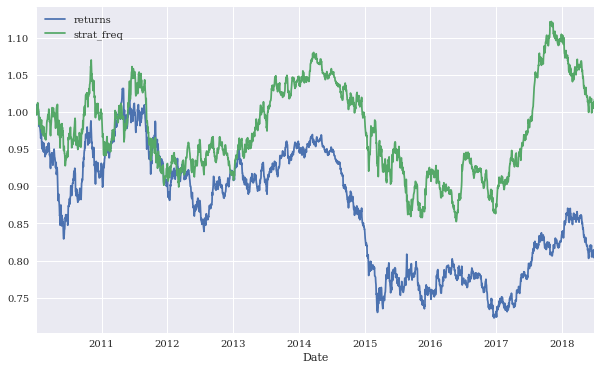

In [177]:
data[['returns','strat_freq']].cumsum().apply(np.exp).plot(figsize=(10,6))

## Machine Learning Classification

### Two Binary Features

In [178]:
#import models
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC #support vector machine

In [179]:
C=1
#instantiate models
models = {
    'log_reg': linear_model.LogisticRegression(C=C),
    'gauss_nb': GaussianNB(),
    'svm': SVC(C=C)
}

In [180]:
#fit models
def fit_models(data):  
    mfit = {model: models[model].fit(data[cols_bin], data['direction'])
            for model in models.keys()} 

In [181]:
fit_models(data)

In [182]:
# predict
def derive_positions(data):  
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])

In [183]:
derive_positions(data)

In [184]:
def evaluate_strats(data):  
    global sel
    sel = []
    for model in models.keys():
        col = 'strat_' + model 
        data[col] = data['pos_' + model] * data['returns']
        sel.append(col)
    sel.insert(0, 'returns')

In [185]:
evaluate_strats(data)

In [186]:
sel.insert(1, 'strat_freq') # inserts strat freq from  before

LOG REG and Gaussian Naive Bayes perform roughly the same and well.

In [187]:
data[sel].sum().apply(np.exp)  

returns           0.813126
strat_freq        1.016673
strat_log_reg     1.385460
strat_gauss_nb    1.385460
strat_svm         1.016673
dtype: float64

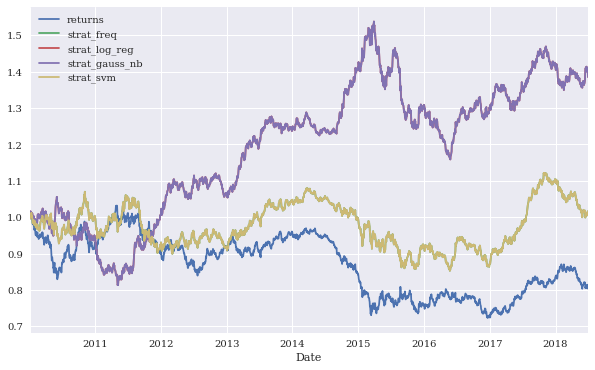

In [188]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_07.png')

### Five Binary Features

Increasing the number of binary features increases the data input to the model so that the ML models are better informed. This should improve their prediction accuracy.

In [189]:
#Reassign data
data = pd.DataFrame(raw[symbol])
data['returns'] = np.log(data / data.shift(1))
data['direction'] = np.sign(data['returns'])

In [192]:
#Increase the number of lags
lags = 5 
create_lags(data)
data.dropna(inplace=True)
create_bins(data)

In [193]:
data.dropna(inplace=True)
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-11,1,0,1,0,1
2010-01-12,1,1,0,1,0
2010-01-13,0,1,1,0,1
2010-01-14,1,0,1,1,0
2010-01-15,0,1,0,1,1


In [194]:
fit_models(data)

In [195]:
derive_positions(data)

In [196]:
evaluate_strats(data)

In [197]:
data[sel].sum().apply(np.exp)

returns           0.810644
strat_log_reg     1.191997
strat_gauss_nb    1.191997
strat_svm         2.364393
dtype: float64

<AxesSubplot:xlabel='Date'>

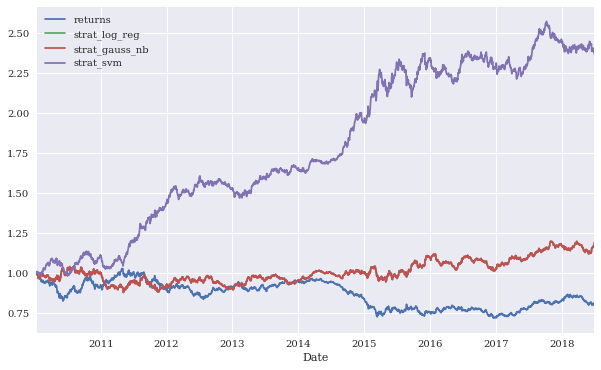

In [198]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10,6))

### Five Digitized Features

Instread of just +ve (1) and -ve (-1) movements. Why not quantify the features into discrete boxes depening on HOW +ve or -ve a movement is? This makes the model more quantitative.

The features are digitized based on the standard deviation of the signal. This should be noted when considering if the model is over fit or not. 

In [199]:
mu = data['returns'].mean()  
v = data['returns'].std() 
bins = [mu - v, mu, mu + v]  
bins 

[-0.005924269398870448, -9.498932088272987e-05, 0.005734290757104988]

In [200]:
create_bins(data, bins)

In [201]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-11,3,0,2,1,3
2010-01-12,3,3,0,2,1
2010-01-13,1,3,3,0,2
2010-01-14,2,1,3,3,0
2010-01-15,1,2,1,3,3


In [202]:
fit_models(data)

In [136]:
derive_positions(data)

In [203]:
evaluate_strats(data)

In [204]:
data[sel].sum().apply(np.exp)

returns           0.810644
strat_log_reg     1.191997
strat_gauss_nb    1.191997
strat_svm         2.364393
dtype: float64

<AxesSubplot:xlabel='Date'>

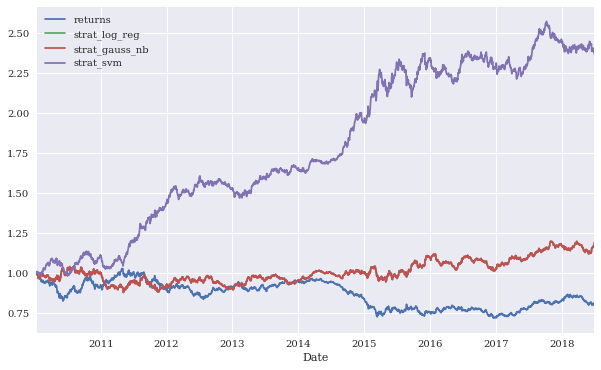

In [205]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10,6))

### Sequential Test-Train Splits

I (and through extension, Hilspich) have talked about overfitting before this. Test-train splits aims to eliminate this by using a different data set training the model and testing the model. Test-Train splits are more representative of a real-life implementation of these models where they are trained on historic data and 'tested' or implemented in a real-life on live data.

In [206]:
split = int(len(data)*0.5) #half test, half train

In [207]:
train = data.iloc[:split].copy() # as sequential: 1st half is test, 2nd half is train. 

In [208]:
fit_models(train)

In [209]:
test = data.iloc[split:].copy() # as sequential: 1st half is test, 2nd half is train. 

In [210]:
derive_positions(test)

In [211]:
evaluate_strats(test)

As hypothesized, the overfitting in previous applications of the ML techniques has caused returns to be unrealistically applicable. The sequential test-train split provides a better outlook on the algorithms performance. But we can do better. Sequential training is bound by chronological order, whereas a randomized test-train split would allow for the test and the train to be representative of the same period of time. 

In [212]:
data[sel].sum().apply(np.exp)

returns           0.810644
strat_log_reg     1.191997
strat_gauss_nb    1.191997
strat_svm         2.364393
dtype: float64

<AxesSubplot:xlabel='Date'>

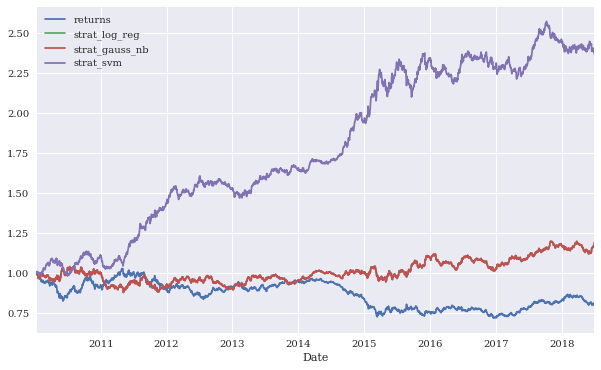

In [213]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10,6))

### Random Test-Train Splits

In [215]:
from sklearn.model_selection import train_test_split

In [216]:
train, test = train_test_split(data, test_size = 0.5, shuffle=True, random_state=100)

In [217]:
train = train.copy().sort_index() # sorted into chronological order, from random 
test = test.copy().sort_index()

In [220]:
fit_models(train)
derive_positions(test)
test[sel].sum().apply(np.exp)

returns           0.736500
strat_log_reg     0.979398
strat_gauss_nb    0.979398
strat_svm         1.498649
dtype: float64

<AxesSubplot:xlabel='Date'>

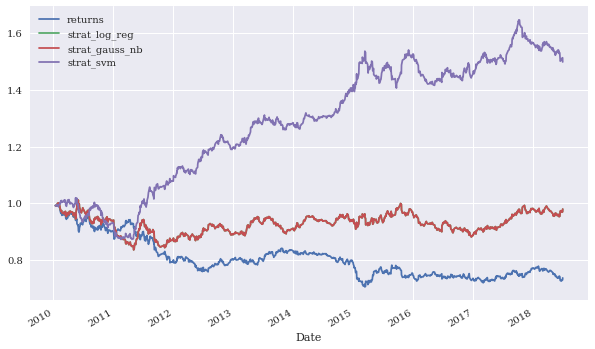

In [221]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10,6))

### Deep Neural Networks

#### DNNs with scikit-learn

In [223]:
from sklearn.neural_network import MLPClassifier

In [225]:
model = MLPClassifier(solver= 'lbfgs', alpha = 1e-5,
                      hidden_layer_sizes = 2* [250], #key part of NNs
                      random_state=1)

In [226]:
%time model.fit(data[cols_bin], data['direction']) # just traininng on direction not the lags

Wall time: 16 s


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[250, 250], random_state=1,
              solver='lbfgs')

Without test-train splits...

In [227]:
data['pos_dnn_sk'] = model.predict(data[cols_bin])

In [228]:
data['strat_dnn_sk'] = data['pos_dnn_sk'] * data['returns']

In [229]:
data[['returns','strat_dnn_sk']].sum().apply(np.exp)

returns          0.810644
strat_dnn_sk    31.582484
dtype: float64

<AxesSubplot:xlabel='Date'>

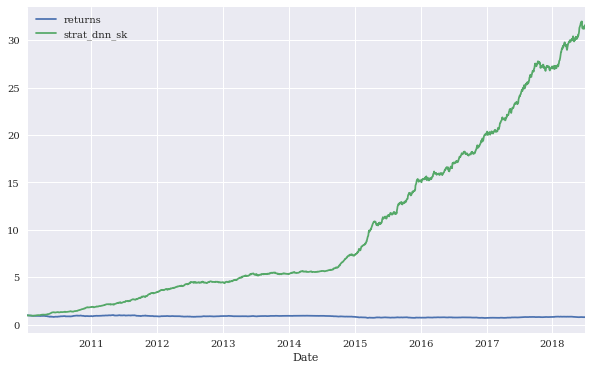

In [232]:
data[['returns','strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10,6))

...with test-train splits

In [233]:
train, test = train_test_split(data, test_size=0.5, random_state=100)
train = train.copy().sort_index()
test = test.copy().sort_index()

In [239]:
#re-trains
model = MLPClassifier(solver='lbfgs', alpha= 1e-5, max_iter=500,
                     hidden_layer_sizes =  3 *[500], # more layers and more nodes per layer
                     random_state = 1)

In [240]:
%time model.fit(train[cols_bin], train['direction']) # just training on direction not the lags 

Wall time: 2min 27s


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[500, 500, 500], max_iter=500,
              random_state=1, solver='lbfgs')

In [241]:
test['pos_dnn_sk'] = model.predict(test[cols_bin])

In [242]:
test['strat_dnn_sk'] = test['pos_dnn_sk'] *test['returns']

In this particular test-train split the resulting strategy using the SKLearn DNN is only marginally better than long only! Perhaps, one should add more data, use more lags (or other indicators), and nodes to increase the accuracy.

In [243]:
test[['returns','strat_dnn_sk']].sum().apply(np.exp)

returns         0.736500
strat_dnn_sk    0.789848
dtype: float64

<AxesSubplot:xlabel='Date'>

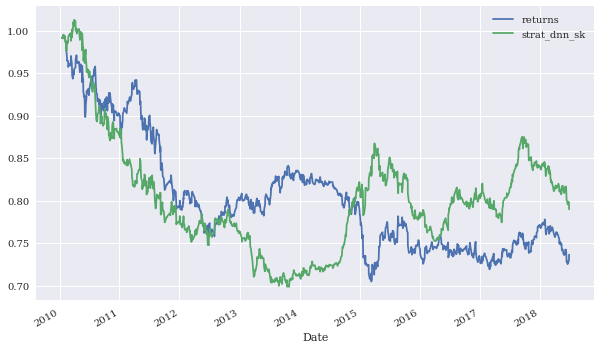

In [244]:
test[['returns','strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10,6))

#### DNNs with TensorFlow

In [82]:
#TO ADD